## **1. 라이브러리 불러오기**

In [1]:
import os

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


import seaborn as sns

%matplotlib inline

import itertools

In [2]:
sm.__version__

'0.13.0'

## **2. 데이터 불러오기**

In [3]:
elec_df = pd.read_csv('data/Electric_Production.csv')
elec_df.head(10)

,DATE,Value
0,01-01-1985,72.5052
1,02-01-1985,70.6720
2,03-01-1985,62.4502
3,04-01-1985,57.4714
4,05-01-1985,55.3151
5,06-01-1985,58.0904
6,07-01-1985,62.6202
7,08-01-1985,63.2485
8,09-01-1985,60.5846
9,10-01-1985,56.3154


In [4]:
elec_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    397 non-null    object 
 1   Value   397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [5]:
elec_df.columns=['Date', 'Consumption']
elec_df = elec_df.dropna()
elec_df['Date'] = pd.to_datetime(elec_df['Date'])
elec_df.set_index('Date', inplace=True) #set date as index

In [6]:
elec_df.head(20)

,Consumption
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
1985-06-01,58.0904
1985-07-01,62.6202
1985-08-01,63.2485
1985-09-01,60.5846


In [7]:
elec_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


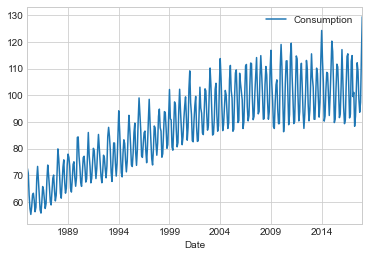

In [8]:
fig = elec_df.plot()

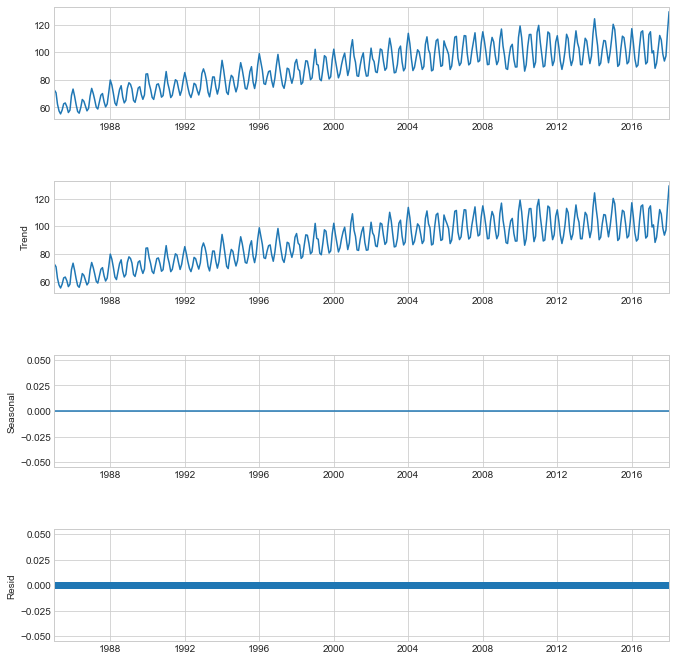

In [9]:
# Seasonal decomposition plot : Seasonal decomposition using moving averages.
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

#sm.__version__ '0.10.1'
#decompostion = sm.tsa.seasonal_decompose(elec_df, model = 'additive', freq = 12)
#sm.__version__ '0.13.0'
decompostion = sm.tsa.seasonal_decompose(elec_df, model = 'additive', period =1)

fig = decompostion.plot()
fig.set_size_inches(10,10)
plt.show()

# 아래 그래프를 데이터로 추출 https://dodonam.tistory.com/89
# decompostion.observed
# decompostion.trend
# decompostion.seasonal
# decompostion.resid

In [10]:
train_data, test_data = train_test_split(elec_df, test_size = 0.3, shuffle = False)

time : 0.03636431694030762


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


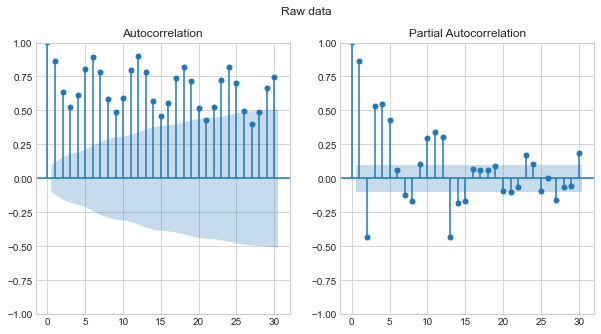

In [11]:
# ACF, PACF

import time
start = time.time()  # 시작 시간 저장

fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Raw data')
sm.graphics.tsa.plot_acf(elec_df, lags = 30, ax = ax[0])
sm.graphics.tsa.plot_pacf(elec_df, lags = 30, ax = ax[1])
print("time :", time.time() - start)

In [12]:
# Dickey-Fuller test
# p-value가 0.05보다 크면 비정상성

result = adfuller(elec_df["Consumption"])
print('p-value : ', result[1])

print('-------------------------------------------------------------------------------------------------------')

dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in result[4].items(): 
    dfoutput['Critical Value (%s)'%key] = value
pvalue = result[1]
if pvalue < 0.05:
    print('p-value = %.4f. The series is likely stationary.' % pvalue)
else:
    print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
print(dfoutput)

p-value :  0.18621469116586592
-------------------------------------------------------------------------------------------------------
p-value = 0.1862. The series is likely non-stationary.
Test Statistic                  -2.256990
p-value                          0.186215
#Lags Used                      15.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


In [13]:
# Differencing 차분

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['Consumption'].diff() #default가 1차 차분
diff_train_data = diff_train_data.dropna() # 차분 하면 마지막 값이 결측치
print('------ Raw data -----')
print(train_data)
print('------ Differenced data -----')
print(diff_train_data)

------ Raw data -----
            Consumption
Date                   
1985-01-01      72.5052
1985-02-01      70.6720
1985-03-01      62.4502
1985-04-01      57.4714
1985-05-01      55.3151
...                 ...
2007-09-01     101.5316
2007-10-01      93.0068
2007-11-01      93.9126
2007-12-01     106.7528
2008-01-01     114.8331

[277 rows x 1 columns]
------ Differenced data -----
Date
1985-02-01    -1.8332
1985-03-01    -8.2218
1985-04-01    -4.9788
1985-05-01    -2.1563
1985-06-01     2.7753
               ...   
2007-09-01   -12.5720
2007-10-01    -8.5248
2007-11-01     0.9058
2007-12-01    12.8402
2008-01-01     8.0803
Name: Consumption, Length: 276, dtype: float64


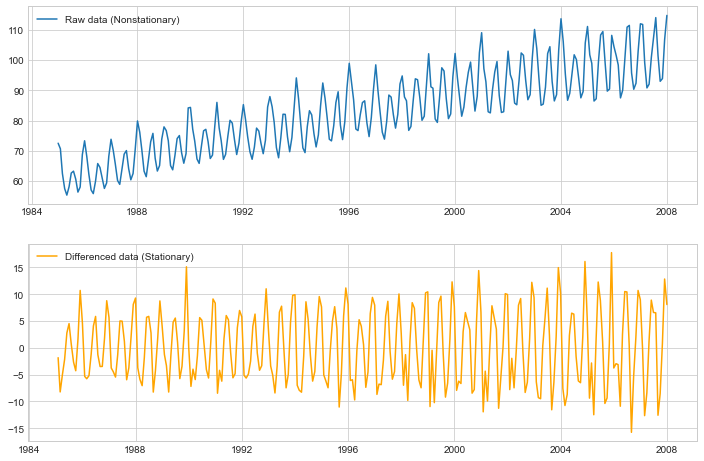

In [14]:
# Differenced data plot

plt.figure(figsize = (12,8))
plt.subplot(211)
plt.plot(train_data['Consumption'])
plt.legend(['Raw data (Nonstationary)'])

plt.subplot(212)
plt.plot(diff_train_data, 'orange')
plt.legend(['Differenced data (Stationary)'])

plt.show()

C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


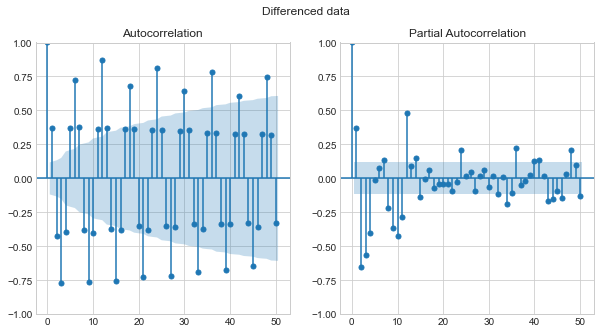

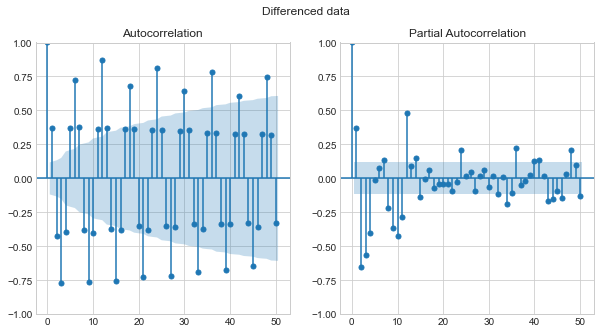

In [15]:
# ACF, PACF

fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Differenced data')
sm.graphics.tsa.plot_acf(diff_train_data, lags = 50, ax = ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data, lags = 50, ax = ax[1])

In [16]:
# Dickey-Fuller test
# p-value가 0.05보다 크면 비정상성

result = adfuller(diff_train_data)
print('p-value : ', result[1])

print('-------------------------------------------------------------------------------------------------------')

dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in result[4].items(): 
    dfoutput['Critical Value (%s)'%key] = value
pvalue = result[1]
if pvalue < 0.05:
    print('p-value = %.4f. The series is likely stationary.' % pvalue)
else:
    print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
print(dfoutput)

p-value :  1.5409359664632496e-08
-------------------------------------------------------------------------------------------------------
p-value = 0.0000. The series is likely stationary.
Test Statistic                -6.448910e+00
p-value                        1.540936e-08
#Lags Used                     1.400000e+01
Number of Observations Used    2.610000e+02
Critical Value (1%)           -3.455656e+00
Critical Value (5%)           -2.872678e+00
Critical Value (10%)          -2.572705e+00
dtype: float64


In [17]:
# ARIMA model fitiing 
# The (p, d, q) order of the model for the number of AR parameters, differences, and MA parameters to use.

# sm.__version__ '0.13.0'
#from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1,1,0))
model_fit = model.fit()
model_fit.summary()

C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  277
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -901.883
Date:                Sat, 27 Nov 2021   AIC                           1807.766
Time:                        02:11:29   BIC                           1815.006
Sample:                    01-01-1985   HQIC                          1810.671
                         - 01-01-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3683      0.068      5.419      0.000       0.235       0.501
sigma2        40.3253      4.032     10.000      0.000      32.422      48.229
===================================================================================
Ljung-Box (L1) (Q):                  15.70   Jarque-Bera (JB):                 3.01
Prob(Q):                              0.00   Prob(JB):                         0.22
Heteroskedasticity (H):               2.50   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RSS : nan


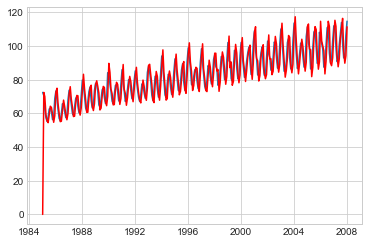

In [18]:
# 0.10.2
#model_fit.plot_predict()

# 0.13.1
plt.plot(train_data)
plt.plot(model_fit.fittedvalues, color='red')
print('RSS : %f' %sum((model_fit.fittedvalues-diff_train_data)**2))

In [19]:
# Parameter search

print('Examples of parameter combinations for Seadonal ARIMA')
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p, d, q))

aic = []
for i in pdq:
    model = ARIMA(train_data, order=(i))
    model_fit = model.fit()
    print('ARIMA:', i, '>> AIC :', round(model_fit.aic,2))
    aic.append(round(model_fit.aic,2))

# 에러 
# The computed initial MA coefficients are not invertible
# You should induce invertibility, choose a different model order, or you can
# pass your own start_params.
# SARIMA 쓰던지 12버전 이후의 statsmodels.tsa.arima.model.ARIMA 사용

C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Examples of parameter combinations for Seadonal ARIMA
ARIMA: (0, 1, 0) >> AIC : 1845.93
ARIMA: (0, 1, 1) >> AIC : 1763.91


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency informa

ARIMA: (0, 1, 2) >> AIC : 1707.95
ARIMA: (1, 1, 0) >> AIC : 1807.77
ARIMA: (1, 1, 1) >> AIC : 1765.55


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA: (1, 1, 2) >> AIC : 1685.43
ARIMA: (2, 1, 0) >> AIC : 1661.0


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency informa

ARIMA: (2, 1, 1) >> AIC : 1525.89
ARIMA: (2, 1, 2) >> AIC : 1422.21


C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
model_opt = ARIMA(train_data.values, order=(2, 1, 2))

model_opt_fit = model_opt.fit()
model_opt_fit.summary()

C:\Users\anjui\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  277
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -706.106
Date:                Sat, 27 Nov 2021   AIC                           1422.213
Time:                        02:11:30   BIC                           1440.315
Sample:                             0   HQIC                          1429.477
                                - 277                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.002    471.918      0.000       0.996       1.004
ar.L2         -0.9994      0.001   -903.588      0.000      -1.002      -0.997
ma.L1         -1.0553      0.019    -56.305      0.000      -1.092      -1.019
ma.L2          0.9876      0.030     32.801      0.000       0.929       1.047
sigma2         9.3954      0.701     13.394      0.000       8.021      10.770
===================================================================================
Ljung-Box (L1) (Q):                   3.55   Jarque-Bera (JB):                 7.07
Prob(Q):                              0.06   Prob(JB):                         0.03
Heteroskedasticity (H):               2.09   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
# forcast 대신 get_forcast

prediction = model_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
print(prediction.conf_int())
predicted_ub = prediction.conf_int()[:][0]
predicted_lb = prediction.conf_int()[:][1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

[[105.90581487 117.92606807]
 [ 92.32994031 108.86782106]
 [ 82.39238231 102.00615013]
 [ 84.01314907 106.21042294]
 [ 94.01998831 118.81742554]
 [101.06748953 128.55814921]
 [ 96.90332763 126.90653774]
 [ 84.56749757 116.64878843]
 [ 75.33436147 109.10469767]
 [ 77.45586478 112.78971281]
 [ 87.89815381 124.92075793]
 [ 95.35378965 134.23135692]
 [ 91.54761381 132.24025799]
 [ 79.4932883  121.74147731]
 [ 70.4672769  114.01223992]
 [ 72.74943733 117.51812182]
 [ 83.34363389 129.45682071]
 [ 90.96487008 138.57985328]
 [ 87.32901797 136.43688427]
 [ 75.4244064  125.8287939 ]
 [ 66.51172709 118.00817849]
 [ 68.87699353 121.41252317]
 [ 79.54809255 133.23394978]
 [ 87.26172906 142.24263994]
 [ 83.73274252 140.01121416]
 [ 71.92914227 129.34244789]
 [ 63.09279645 121.46742911]
 [ 65.50896675 124.80248353]
 [ 76.22429673 136.53937812]
 [ 83.99685392 145.46722947]
 [ 80.54431743 143.17771766]
 [ 68.81744163 132.47249366]
 [ 60.03840523 124.56207161]
 [ 62.48850331 127.84485657]
 [ 73.23040937

ValueError: operands could not be broadcast together with shapes (120,) (2,) 

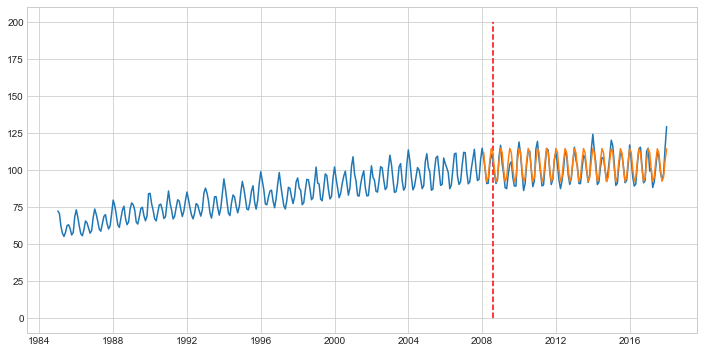

In [22]:
fig, ax= plt.subplots(figsize=(12,6))
ax.plot(elec_df.index, elec_df)
ax.vlines(pd.to_datetime('2008-08-01'), 0,200, linestyle ='--', color='r',
         label = 'Start of  Forcast')

ax.plot(predict_index, predicted_value, label='prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha= 0.1, label='0.95 prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0][0]} prediction results (r2score: {round(r2,2)})')
plt.show()

In [ ]:
print('Examples of parameter combinations of SARIMA...')
p = range(0,3)
d = range(1,2)
q = range(0,3)

pdq = list(itertools.product(p,d,q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
print(pdq)
print(seasonal_pdq)

aic = []
params = []
for i in pdq:
    for j in seasonal_pdq:
        try: 
            model = SARIMAX(train_data.values, order=(i), seasonal_order=(j))
            model_fit = model.fit()
            print(f'SARIMA parameter : {i} {j} >> AIC: {round(model_fit.aic,2)}')
            params.append((i,j))
            aic.append(round(model_fit.aic,2))
        except:
            continue
        # try, except 구문 , try 중 에러 나면 except 수행

In [ ]:
print(min(aic))
# ctrl+F SARIMA parameter : (1, 1, 0) (1, 1, 2, 12) >> AIC: 751.15

optimal = [(params[i], j) for i, j in enumerate(aic) if j==min(aic)]
optimal

In [ ]:
#model_opt = SARIMAX(train_data, order = (1,1,0), seasonal_order = (1,1,2,12))

model_opt = SARIMAX(train_data, order = optimal[0][0][0], seasonal_order = optimal[0][0][1])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

In [ ]:
# ARIMA와 코드가 살짝 다름(forcast 대신 get_forcast)

prediction = model_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int().iloc[:,0]
predicted_lb = prediction.conf_int().iloc[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

In [ ]:
fig, ax= plt.subplots(figsize=(12,6))
ax.plot(elec_df.index, elec_df)
ax.vlines(pd.to_datetime('2008-08-01'), 0,200, linestyle ='--', color='r',
         label = 'Start of  Forcast')

ax.plot(predict_index, predicted_value, label='prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha= 0.1, label='0.95 prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optimal[0][0][0], optimal[0][0][1]} prediction results (r2score: {round(r2,2)})')
plt.show()